# High-throughput ion suppression correction

SpaceM datasets are usually stored as annotated data-matrices, separately for individual wells. With this notebooks, these individual files are corrected for ion suppression on the pixel-level and then deconvoluted to cell-level. All resulting files are saved separately by well to the target_path and the impact of the correction briefly shown for visual inspection.

In [1]:
import os
import platform
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import statistics as st
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.formula.api as smf
import seaborn as sns
import re
from importlib import reload
import json
import sys
sys.path.append('/home/mklein/spacem')
sys.path.append('/home/mklein/FDA_project')

from src.correction import (add_normalization_factors, 
                            correct_quantile_inplace,
                            deconvolution_spacem,
                            get_overlap_data,
                            add_overlap_matrix_spacem
                           )
from src import const 
from SpaceM.lib.modules import (
    overlap_analysis,
    single_cell_analysis_normalization
)

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

The original data lies on the groups shared data storage. Corrected files will be saved in a separate location, preserving the well-specific folder structure.

In [2]:
if platform.system() == "Darwin":
    source_path = '/Volumes/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/Volumes/mklein/FDA_project/data/Lx_Glioblastoma'
else:
    source_path = '/g/alexandr/smenon/2022-07-13_Glioblastoma/processed_files'
    target_path = '/home/mklein/FDA_project/data/Lx_Glioblastoma'
    
# TODO: implement topX reference ion pool.
reference_pool = {'top': 10}
deconv_default_min_overlap = 0.0

In [3]:
# Parameters
source_path = "/home/mklein/Raw Data/2022-01-31_PancreaticCancer"
target_path = "/home/mklein/FDA_project/data/Lx_Pancreatic_Cancer"
condition_name = "condition"
well_name = "rowcol"
analysis_path = "/home/mklein/FDA_project/analysis/Lx_Pancreatic_Cancer"
notebooks = [
    "pipeline_01_correction.ipynb",
    "pipeline_02_processing.ipynb",
    "pipeline_03_evaluation.ipynb",
]
project = "Lx_Pancreatic_Cancer"


In [4]:
samples = []
for dirpath, dirnames, filenames in os.walk(source_path):
        if 'analysis' in dirnames:
            samples.append(re.sub(source_path+'/?', '', dirpath))
samples

['S1/W5',
 'S1/W6',
 'S1/W7',
 'S1/W8',
 'S2/W5',
 'S2/W6',
 'S2/W7',
 'S2/W8',
 'S3/W5',
 'S3/W6',
 'S3/W7',
 'S3/W8']

In [5]:
files = {
        'config': '../config.json',
        'sm_matrix': 'ablation_mark_analysis/spatiomolecular_adata.h5ad',
        'overlap_regions': 'overlap_analysis2/overlap.regions.csv',
        'mark_regions': 'overlap_analysis2/ablation_mark.regions.csv',
        'cell_regions': 'overlap_analysis2/cell.regions.csv',
        'cell_sm_matrix': 'single_cell_analysis/spatiomolecular_adata.h5ad',
    }

In [6]:
def assign_average_tpo(am_adata, overlap_data, min_overlap, method=np.mean):
    if min_overlap is None:
        min_overlap = 0
    
    overlap = overlap_data.overlap_regions
    overlap['am_id'] = overlap['am_id'].astype(str)
    overlap['cell_id'] = overlap['cell_id'].astype(str)
    merged_df = pd.merge(overlap[['am_id', 'cell_id']], am_adata.obs[const.TPO], left_on='am_id', right_index=True)
    merged_df = merged_df[merged_df[const.TPO] >= min_overlap]
    
    mean_df = merged_df[['cell_id', 'correction_total_pixel_overlap']].groupby('cell_id', group_keys=False).agg(method)
#     mean_df = merged_df[['cell_id', 'correction_total_pixel_overlap']].groupby('cell_id', group_keys=False).agg(lambda x: method(x))
    return mean_df[const.TPO]

In [7]:
def correct_sample_spacem(sample):
    
    sample_path = os.path.join(source_path, sample, "analysis")
    sample = re.sub('/', '_', sample)
    
    if not os.path.exists(os.path.join(target_path, sample)):
        os.makedirs(os.path.join(target_path, sample))

    # get appropriate file paths for the processed well
    project_files = {k: os.path.join(sample_path, v) for k, v in files.items()}

    if os.path.exists(project_files['config']):
        with open(project_files['config']) as json_file:
            data = json.load(json_file)
        deconv_info = data['single_cell_analysis']
        if deconv_info['ablation_marks_min_overlap_ratio'] is None:
            deconv_info['ablation_marks_min_overlap_ratio'] = deconv_default_min_overlap
    else:
        deconv_info = None
        print('No well config file found. Using default deconvolution parameters.')
    # load required files
    cell_regions = pd.read_csv(project_files['cell_regions'])
    mark_regions = pd.read_csv(project_files['mark_regions'])
    overlap_regions = pd.read_csv(project_files['overlap_regions'])
    
    sm_matrix = sc.read(os.path.join(sample_path, files['sm_matrix']))
    cell_sm_matrix = sc.read(os.path.join(sample_path, files['cell_sm_matrix']))
       
    add_overlap_matrix_spacem(sm_matrix, cell_regions, mark_regions, overlap_regions)
    
    add_normalization_factors(adata=sm_matrix, method=st.median)

    # perform the actual quantile regression
    corr_sm_matrix = correct_quantile_inplace(adata=sm_matrix, 
        reference_ions=sm_matrix.var_names, 
        correct_intersect = True,
        n_jobs=5)
    
    # perform pixel-cell-deconvolution
    overlap_data = get_overlap_data(cell_regions, mark_regions, overlap_regions)
    corr_cell_sm_matrix = deconvolution_spacem(adata=corr_sm_matrix, 
        overlap_data=overlap_data,
        raw_adata=cell_sm_matrix,
        deconvolution_params=deconv_info)
    gen_cell_sm_matrix = deconvolution_spacem(adata=sm_matrix,
        overlap_data=overlap_data,
        raw_adata=cell_sm_matrix,
        deconvolution_params=deconv_info)
    
    # hand over TPOs to spatiomolecular matrix for downstream analysis
    min_overlap = deconv_info['ablation_marks_min_overlap_ratio']
    corr_cell_sm_matrix.obs['list_TPO'] = assign_average_tpo(sm_matrix, overlap_data, min_overlap, method=lambda x: ";".join(x.astype(str)))
    gen_cell_sm_matrix.obs['list_TPO'] = assign_average_tpo(sm_matrix, overlap_data, min_overlap, method=lambda x: ";".join(x.astype(str)))
    
    # write the generated files to the dedicated project location.
    corr_sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata_corrected.h5ad'))
    sm_matrix.write(os.path.join(target_path, sample, 'am_spatiomolecular_adata.h5ad'))
    corr_cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata_corrected.h5ad'))
    cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata_spacem.h5ad'))
    gen_cell_sm_matrix.write(os.path.join(target_path, sample, 'cells_spatiomolecular_adata.h5ad'))
    
    return (sample, cell_sm_matrix, corr_cell_sm_matrix, sm_matrix, corr_sm_matrix, deconv_info)

This is the actual correction pipeline.

In [8]:
adata_list = Parallel(n_jobs=7)(delayed(correct_sample_spacem)(sample) for sample in tqdm(samples))
# adata_list = [correct_sample_spacem(sample) for sample in tqdm(['I4'])]

  0%|                                                                                                                                        | 0/12 [00:00<?, ?it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 7/12 [00:00<00:00, 57.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 94.75it/s]

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [9]:
# reshape data for immediate analysis
am_adata_dict = {item[0]: item[3] for item in adata_list}
am_adata_cor_dict = {item[0]: item[4] for item in adata_list}
adata_dict = {item[0]: item[1] for item in adata_list}
adata_cor_dict = {item[0]: item[2] for item in adata_list}

am_adata = ad.concat(am_adata_dict, label='well', index_unique="_", merge="first")
am_adata_cor = ad.concat(am_adata_cor_dict, label='well', index_unique="_", merge='first')
adata = ad.concat(adata_dict, label='well', index_unique="_", merge="first")
adata_cor = ad.concat(adata_cor_dict, label='well', index_unique="_", merge="first")

deconv_dict = {item[0]: item[5] for item in adata_list}
deconv_table = pd.DataFrame(deconv_dict).T
deconv_table

,cell_normalization_method,ablation_marks_min_overlap_ratio,fluorescence_channels,cell_ion_max_correlation_distance,ions_of_interest
S1_W5,biggest_overlap_raw,0.3,[DAPI],None,[]
S1_W6,biggest_overlap_raw,0.3,[DAPI],None,[]
S1_W7,biggest_overlap_raw,0.3,[DAPI],None,[]
S1_W8,biggest_overlap_raw,0.3,[DAPI],None,[]
S2_W5,biggest_overlap_raw,0.3,[DAPI],None,[]
S2_W6,biggest_overlap_raw,0.3,[DAPI],None,[]
S2_W7,biggest_overlap_raw,0.3,[DAPI],None,[]
S2_W8,biggest_overlap_raw,0.3,[DAPI],None,[]
S3_W5,biggest_overlap_raw,0.3,[DAPI],None,[]
S3_W6,biggest_overlap_raw,0.3,[DAPI],None,[]


Every analysed pixel is characterized by its total overlap with cellular regions. The raw data shows no clear association between this overlap and acquired ion intensities. However, after the ion suppression correction, pixels with smaller overlap clearly have lower corresponding intensities (only shown for one metabolite). 

In [10]:
import warnings
warnings.filterwarnings('ignore')
from src.correction import normalize_proportion_ratios
       

def plot_all_wells(adata, ions=None, row='well', x=const.TPO, ratio=True):
    
    top_wells = list(set(adata.obs[row]))[:5]
    adata = adata[adata.obs[row].isin(top_wells)]
    
    if ions is None and not ratio:
        ions = list(adata.var_names[:5])
    elif ions is None and ratio:
        ions = list(normalize_proportion_ratios(intensities_ad=adata).to_df().sum().sort_values().tail().index)
        
    yscale = 'intensity'
    if ratio:
        adata = normalize_proportion_ratios(intensities_ad=adata)
        yscale = 'intensity_proportion_ratio'

    plot_df = sc.get.obs_df(adata, keys=[row, x] + ions).melt(id_vars=[row, x], var_name='ion', value_name=yscale)
    plot_df= plot_df[plot_df[yscale] > 0]
    
    if ratio:
        plot_df[yscale] = np.log10(plot_df[yscale])
        plot_df[x] = np.log10(plot_df[x])
       
    graph = sns.FacetGrid(plot_df, row=row, col='ion', sharey=False, margin_titles=True)
    graph.map(sns.histplot, x, yscale, bins=50, stat='proportion').add_legend()
        
    params = []

    for well in list(set(plot_df[row])):
        for i in ions:
            q_df = plot_df[(plot_df['ion'] == i) & (plot_df[row] == well)]
            if len(q_df) == 0:
                params[i] = {'Intercept': np.nan, x: np.nan}
                continue
            model = smf.quantreg(yscale+' ~ '+x, q_df)
            qrmodel = model.fit(q=0.5)
            params.append({'ion': i, row: well, 'Intercept': qrmodel.params[0], x: qrmodel.params[1]})
    
        
    return pd.DataFrame(params).sort_values(['ion', row]).set_index(['ion', row])
    
def compare_pre_post_correction(adata, adata_cor, ions=None, ratio=True):
    if ions is None and not ratio:
        ions = list(adata.var_names[:5])
    elif ions is None and ratio:
        ions = list(normalize_proportion_ratios(intensities_ad=adata).to_df().sum().sort_values().tail().index)
        
    df1 = plot_all_wells(adata, ions=ions, ratio=ratio)
    df2 = plot_all_wells(adata_cor, ions=ions, ratio=ratio)
    return pd.merge(df1, df2, right_index=True, left_index=True, suffixes=('_uncorrected', '_ISM_correction'))

In [11]:
am_adata.obs[const.TPO] = am_adata_cor.obs[const.TPO]

Intercept_uncorrected  \
ion            well                           
C26H30O13+K    S1_W6               0.077756   
               S1_W7              -0.128003   
               S2_W6               0.401527   
               S3_W6               0.235961   
               S3_W7               0.119557   
C26H48NO10P+Na S1_W6               0.068475   
               S1_W7               0.273534   
               S2_W6               0.403137   
               S3_W6               0.028320   
               S3_W7               0.013711   
C33H64NO9P+Na  S1_W6               0.117910   
               S1_W7              -0.102749   
               S2_W6               0.430767   
               S3_W6               0.319502   
               S3_W7              -0.031376   
C44H86NO8P+Na  S1_W6               0.571018   
               S1_W7               0.210328   
               S2_W6               0.606826   
               S3_W6               1.106449   
               S3_W7               0.712221   
C8HF15O2+Na    S1_W6               0.390596   
               S1_W7               0.132606   
               S2_W6               0.398879   
               S3_W6               0.826803   
               S3_W7               0.708841   

                      correction_total_pixel_overlap_uncorrected  \
ion            well                                                
C26H30O13+K    S1_W6                                   -1.227083   
               S1_W7                                   -1.254077   
               S2_W6                                   -1.177665   
               S3_W6                                   -1.182825   
               S3_W7                                   -1.212586   
C26H48NO10P+Na S1_W6                                   -1.084238   
               S1_W7                                   -1.039071   
               S2_W6                                   -1.096532   
               S3_W6                                   -1.050886   
               S3_W7                                   -1.095875   
C33H64NO9P+Na  S1_W6                                   -1.071245   
               S1_W7                                   -1.068264   
               S2_W6                                   -1.062132   
               S3_W6                                   -1.065028   
               S3_W7                                   -1.107885   
C44H86NO8P+Na  S1_W6                                   -0.828457   
               S1_W7                                   -0.975173   
               S2_W6                                   -0.821282   
               S3_W6                                   -0.861212   
               S3_W7                                   -0.920686   
C8HF15O2+Na    S1_W6                                   -0.961577   
               S1_W7                                   -1.019482   
               S2_W6                                   -0.959252   
               S3_W6                                   -0.963722   
               S3_W7                                   -1.085602   

                      Intercept_ISM_correction  \
ion            well                              
C26H30O13+K    S1_W6                  0.077756   
               S1_W7                 -0.128003   
               S2_W6                  0.401527   
               S3_W6                  0.235961   
               S3_W7                  0.119557   
C26H48NO10P+Na S1_W6                  0.068475   
               S1_W7                  0.273534   
               S2_W6                  0.403137   
               S3_W6                  0.028320   
               S3_W7                  0.013711   
C33H64NO9P+Na  S1_W6                  0.117908   
               S1_W7                 -0.102749   
               S2_W6                  0.430767   
               S3_W6                  0.319502   
               S3_W7                 -0.031376   
C44H86NO8P+Na  S1_W6                  0.571018   
               

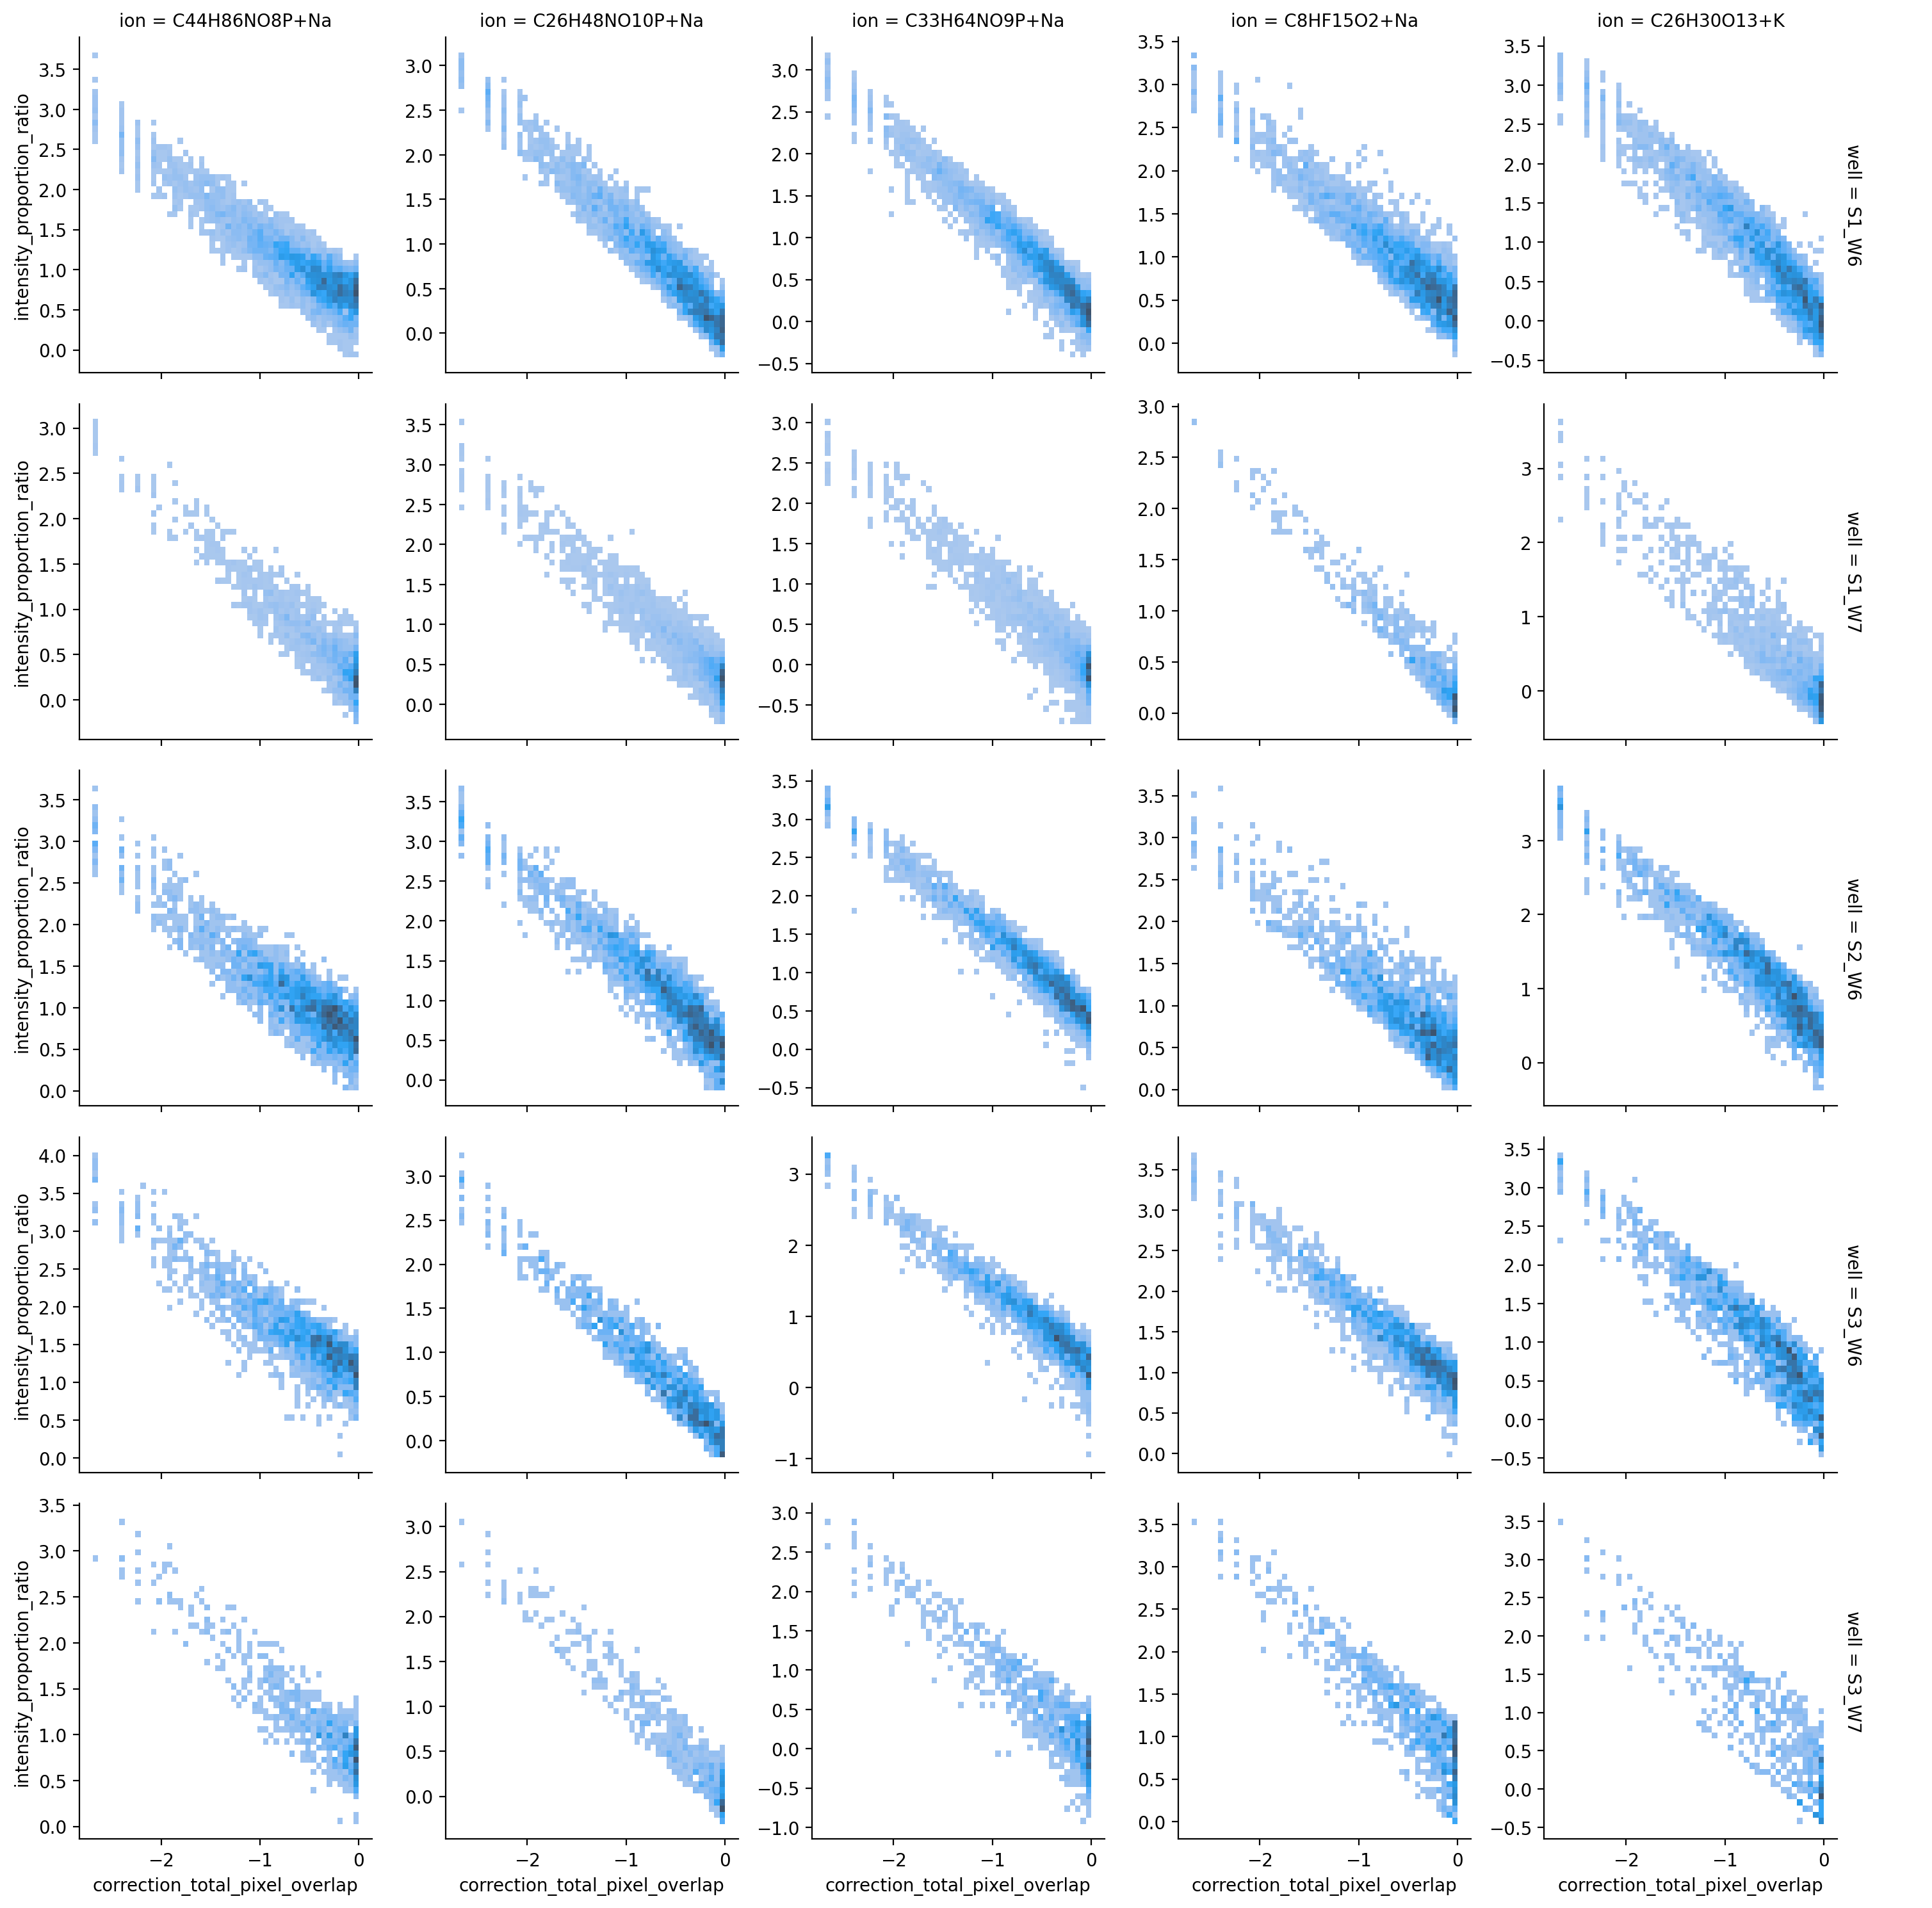

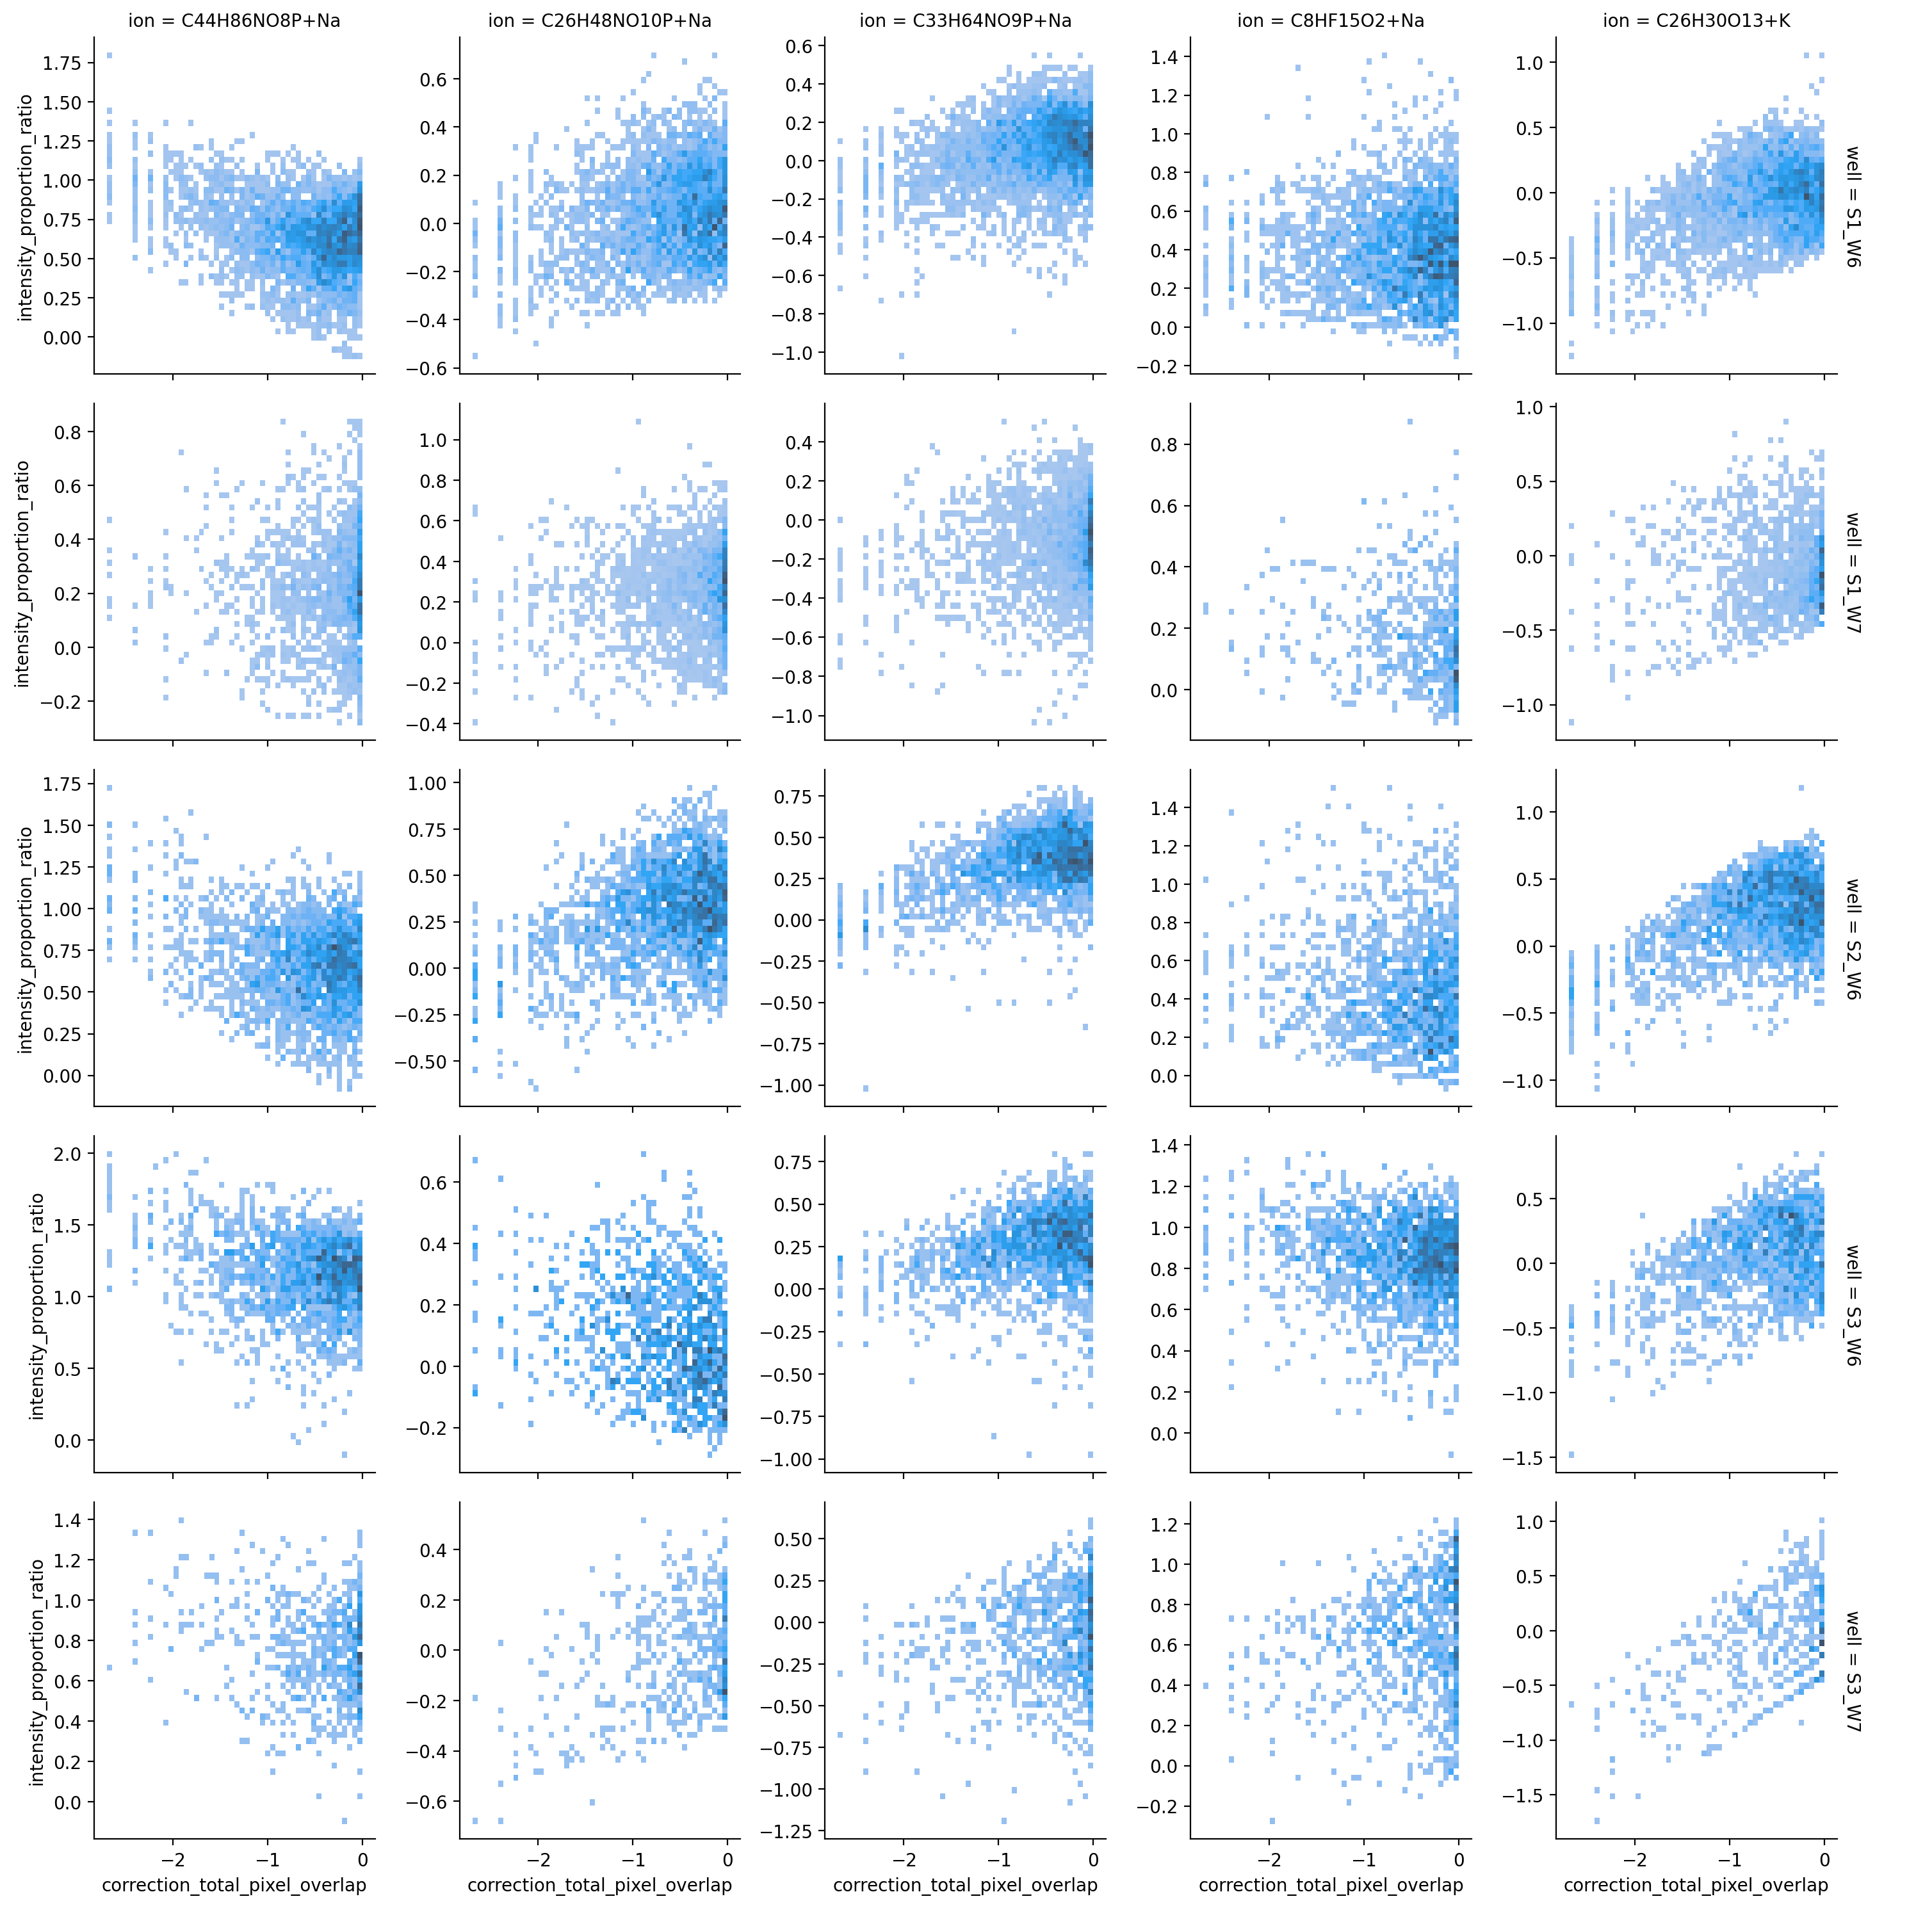

In [12]:
compare_pre_post_correction(am_adata, am_adata_cor)